[Dataset](http://jse.amstat.org/v4n1/datasets.johnson.html)

Percentage of body fat, age, weight, height, and ten body circumference measurements (e.g., abdomen) are recorded for 252 men. Body fat, one measure of health, has been accurately estimated by an underwater weighing technique. Fitting body fat to the other measurements using multiple regression provides a convenient way of estimating body fat for men using only a scale and a measuring tape.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

**Dataset Description**
    - case  Case Number
     pbf_b  Percent body fat using Brozek's equation, 
               457/Density - 414.2
     pbf_s  Percent body fat using Siri's equation, 
               495/Density - 450
     density  Density (gm/cm^3)
     age  Age (yrs)
     weight  Weight (lbs)
     height  Height (inches)
     bmi  Adiposity index = Weight/Height^2 (kg/m^2)
     fat_free_w  Fat Free Weight 
               = (1 - fraction of body fat) * Weight, 
               using Brozek's formula (lbs)
     neck  Neck circumference (cm)
     chest  Chest circumference (cm)
     abdomen  Abdomen circumference (cm) "at the umbilicus and level with the iliac crest"
     hip  Hip circumference (cm)
     thigh  Thigh circumference (cm)
     knee  Knee circumference (cm)
     ankle  Ankle circumference (cm)
     biceps  Extended biceps circumference (cm)
     forearm  Forearm circumference (cm)
     wrist  Wrist circumference (cm) "distal to the styloid processes"

In [2]:
data = pd.read_csv('Fat_data.txt', delim_whitespace=True)
data.head()

,case,pbf_b,pbf_s,density,age,weight,height,bmi,fat_free_w,neck,chest,abdomen,hip,thigh,knee,ankle,biceps,forearm,wrist
0,1,12.6,12.3,1.0708,23,154.25,67.75,23.7,134.9,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,2,6.9,6.1,1.0853,22,173.25,72.25,23.4,161.3,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,3,24.6,25.3,1.0414,22,154.00,66.25,24.7,116.0,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,4,10.9,10.4,1.0751,26,184.75,72.25,24.9,164.7,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,5,27.8,28.7,1.0340,24,184.25,71.25,25.6,133.1,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [3]:
data.shape

(252, 19)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 19 columns):
case          252 non-null int64
pbf_b         252 non-null float64
pbf_s         252 non-null float64
density       252 non-null float64
age           252 non-null int64
weight        252 non-null float64
height        252 non-null float64
bmi           252 non-null float64
fat_free_w    252 non-null float64
neck          252 non-null float64
chest         252 non-null float64
abdomen       252 non-null float64
hip           252 non-null float64
thigh         252 non-null float64
knee          252 non-null float64
ankle         252 non-null float64
biceps        252 non-null float64
forearm       252 non-null float64
wrist         252 non-null float64
dtypes: float64(17), int64(2)
memory usage: 37.5 KB


In [5]:
data = data.drop(['case', 'fat_free_w'], axis=1)
# Remove a few data points (outliers, incorrect values)
data = data.drop([42, 182])
# data = data[data['weight']<300]
# data.shape

Now that the data is loaded, we can check it out. We'll look at the first few cases, then make some plots so we can see how some of the data is distributed. The first two columns are percent body fat (PBF) using the Brozek and Siri formula's, respectively. Every column from "neck" on is the circumference at those locations.

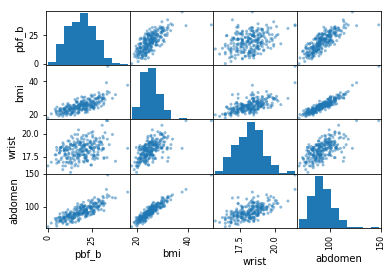

In [6]:
scatter_matrix(data[['pbf_b', 'bmi', 'wrist', 'abdomen']])
plt.show()

In [7]:
data[['pbf_b', 'bmi', 'wrist', 'abdomen']].corr()

,pbf_b,bmi,wrist,abdomen
pbf_b,1.000000,0.724734,0.345454,0.811328
bmi,0.724734,1.000000,0.626866,0.922902
wrist,0.345454,0.626866,1.000000,0.621053
abdomen,0.811328,0.922902,0.621053,1.000000


From this we can see the percent body fat is correlated with weight and body measurements, while height has little if any effect. There are also correlations between body measurements and weight which we'll have to deal with later. I'm going to use a [linear regression model](http://en.wikipedia.org/wiki/Linear_regression) to predict percent body fat from the data.

A linear regression model is a formal way to draw a line through a set of data points. For instance, we can see that when we plot abdomen circumference on the x-axis and percent body fat on the y-axis (first row, fifth column), the data falls along a general upward sloped line. As we would expect, a larger gut indicates more body fat. We can get a decent estimate of this relationship by printing out the plot and drawing a line through the data points by hand. However, we want to find the "best" line. What I mean by "best" is that the line we draw has the least error predicting the existing data points.

We can define any line using an intercept, $\beta_0$,  and a slope, $\beta_1$, as $y = \beta_0 + \beta_1 x$. Here, $y$ is our dependent variable, percent body fat for example, and $x$ is the independent variable, such as abdomen circumference. Depending on the context and conventions, $x$ is also called the explanatory variable, regressor, feature, predictor, and more. Our model is a prediction of the percent body fat $\hat{y}$ using the abdomen circumference $x$,
$$
\hat{y}_i = \beta_0 + \beta_1 x_i,
$$
where the subscript $i$ indicates which data point we are using ($i=1$ is the first data point, and so on). Our goal here is to find values for $\beta_0$ and $\beta_1$ which give us the smallest error $\epsilon_i = y_i - \hat{y}_i$. We can actually find an exact solution to this problem if we minimize the sum of the squares of the errors, 

$$
SSE = \sum_{i=1}^{n} \left|\, y_i - \hat{y}_i \right|^2 ,
$$

using the [ordinary least squares](http://en.wikipedia.org/wiki/Ordinary_least_squares) method. Here I will use the excellent [scikits learn](http://scikit-learn.org/stable/) Python package to fit a linear model to our data.

In [8]:
from sklearn import linear_model

In [9]:
X = data[['abdomen']]
y = data['pbf_b']

In [10]:
# Make an intercept column that is all 1
X['intercept'] = pd.DataFrame(np.ones(len(X)), index=X.index)
# This is the part that fits the linear model to the data
linmodel = linear_model.LinearRegression(fit_intercept=False)
linmodel.fit(X, y)

C:\Users\jmo4cob\AppData\Local\conda\conda\envs\tf\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [11]:
X.head()

,abdomen,intercept
0,85.2,1.0
1,83.0,1.0
2,87.9,1.0
3,86.4,1.0
4,100.0,1.0


In [12]:
print("Coefficients\n"+ '-'*14)
for feature, coef in zip(X.columns, linmodel.coef_):
    print('{}: {:.3f} '.format(feature, coef))

Coefficients
--------------
abdomen: 0.584 
intercept: -35.107 


In [13]:
X.shape

(250, 2)

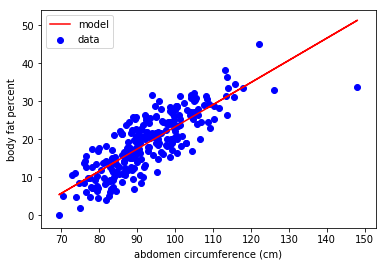

In [14]:
plt.plot(X.iloc[:, 0], linmodel.predict(X), color='r', label ='model')
plt.scatter(X.iloc[:, 0], y , color='b', label='data')
plt.legend()
plt.xlabel('abdomen circumference (cm)')
plt.ylabel('body fat percent')
plt.show()

We see here that our model fits the data pretty well, but I'd like to measure the quality of the fit. A common way to measure the performance of the model is to split the data into a training set and a testing set. You fit the model to the training set, then measure how well it can predict the test set. This is known as cross-validation (CV) and is sort of the industry standard. I'll use scikits learn to perform *k-folds* CV. This method separates the data into $k$ parts (folds). Then, it uses $k-1$ folds to fit the model and then tests the model on the left out fold. Repeat this $k$ times using each fold to test only once.

In [15]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(linmodel, X, y,
                         cv=5, scoring='neg_mean_absolute_error')
print("Mean absolute error: {:.3f}".format(-scores.mean()))

Mean absolute error: 3.756


C:\Users\jmo4cob\AppData\Local\conda\conda\envs\tf\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


We can improve our model by including all the information we have in the data. Using a linear model makes this simple, we just add more coefficients. For each data point we have $m$ features and we can use them to predict the body fat percentage $\hat{y}$:

$$
\hat{y}_i = \beta_0 + \beta_1 x_{i,1} + \beta_2 x_{i,2} + \cdots + \beta_m x_{i,m}
= \sum_{j=1}^{m} \beta_j x_j
$$

where the subscript $j$ indicates our data features and $x_0 = 1$. For convenience, we can write our model in matrix notation:

$$
\hat{y} = X \beta,
$$

$$
\hat{y} = \left( \begin{array}{c}
y_1    \\
y_2    \\
\vdots \\
y_n  \end{array} \right)
\hspace{2em} \beta = \left( \begin{array}{c}
\beta_0  \\
\beta_1  \\
\vdots \\
\beta_m  \end{array} \right)
\hspace{2em} X = \left( \begin{array}{ccccc}
1 & x_{1,1} & x_{1,2} & \cdots & x_{1,m} \\
1 & x_{2,1} & x_{2,2} & \cdots & x_{2,m}  \\
1 & \vdots & \vdots & \ddots & \vdots \\
1 & x_{n,1} & x_{1,2} & \cdots & x_{n,m}  \end{array} \right)
$$

Again, our error is $ \mathbf{\epsilon} = \sum_{i=1}^{n} \left|\, y_i - \hat{y}_i \right|^2 $ which we want to minimize. There is an exact and unique solution for the coefficients that minimize the error:

$$
\hat{\beta} = \left( X^T X \right)^{-1}X^T y
$$


In [16]:
features = data[['height', 'weight', 'age', 'neck', 'chest', 'abdomen', 
                 'hip', 'thigh', 'knee', 'ankle','biceps', 'forearm', 
                 'wrist']]
features.loc[:,'intercept'] = pd.Series(np.ones(len(features)), 
                                        index=features.index)

linmodel = linear_model.LinearRegression(fit_intercept=False)
linmodel.fit(features, data['pbf_b'])

scores = cross_val_score(linmodel, features, y=data['pbf_b'],
                         cv=5, scoring='neg_mean_absolute_error')

print("Coefficients\n"+ '-'*14)
for feature, coef in zip(features.columns, linmodel.coef_):
    print('{}: {:.3f} '.format(feature, coef))
print("Mean absolute error: {:.3f}".format(-scores.mean()))

Coefficients
--------------
height: -0.063 
weight: -0.084 
age: 0.056 
neck: -0.462 
chest: -0.018 
abdomen: 0.889 
hip: -0.192 
thigh: 0.229 
knee: -0.015 
ankle: 0.172 
biceps: 0.171 
forearm: 0.437 
wrist: -1.493 
intercept: -15.725 
Mean absolute error: 3.414


C:\Users\jmo4cob\AppData\Local\conda\conda\envs\tf\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\jmo4cob\AppData\Local\conda\conda\envs\tf\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
